# Getting started

This tutorial introduces basic concepts and practices of PAX.

In [1]:
import jax
import jax.numpy as jnp
import pax
import matplotlib.pyplot as plt
from absl import logging

In [2]:
logging.set_verbosity(logging.FATAL)
plt.rcParams["figure.figsize"] = (3, 2)

To demonstrate the basics of ``pax.Module``, we will define a simple ``Linear`` module with an additional forward pass counter.

In [3]:
class Linear(pax.Module):
    def __init__(self):
        super().__init__()
        with self.add_parameters():
            self.weight = jnp.array(1.0)
            self.bias = jnp.array(0.0)
        
        with self.add_states():
            self.counter = jnp.array(0)

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        self.counter = self.counter + 1
        return self.weight * x + self.bias

    def __repr__(self):
        return f"Linear(weight={self.weight:.3f}, bias={self.bias:.3f}, counter={self.counter})"

The method `self.add_parameters()` returns a context manager that registers new attributes in the scope as *trainable* parameters.
Similarly, `self.add_states()` registers new attributes as *non-trainable* states.

In [4]:
net = Linear()
print(net)

Linear(weight=1.000, bias=0.000, counter=0)


Next, we will create a toy dataset for training purposes.

In [5]:
def create_data(a=-3.0, b=1.5):
    x = jax.random.uniform(pax.next_rng_key(), (128, 1))
    noise = jax.random.normal(pax.next_rng_key(), x.shape) * 0.2
    y = a * x + b + noise
    return x, y

In [6]:
pax.seed_rng_key(42)
x, y = create_data()

PAX keeps a global random key for each thread. We use ``pax.seed_rng_key(42)`` to seed that global random key.
The function `pax.next_rng_key()` returns a random key and also renews the global random key.

In [7]:
def plot_data(x, y):
    plt.scatter(x, y, label="data")
    plt.legend()
    plt.show()

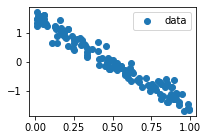

In [8]:
plot_data(x, y)


OK, let's plot the initial predictions of our _Linear_ model.

In [9]:
def plot_prediction(x, y, y_hat):
    plt.scatter(x, y, label="data")
    plt.scatter(x, y_hat, label="prediction")
    plt.legend()

In [10]:
y_hat = net(x)
plot_prediction(x, y, y_hat)
print(net)

ValueError: Cannot modify a module in immutable mode.
Please do this computation inside a function decorated by `pax.pure`.

Oops! PAX prevents us to update `self.counter`. Indeed, PAX modules are immutable by default. The only way to modify a module is to pass it as an argument to a function decorated by `pax.pure`. Below is a working implementation:

In [11]:
@pax.pure
def run(net, x):
    y_hat = net(x)
    return net, y_hat

Note that `pax.pure` only allows `run` to access to a copy of its input module. This is PAX's mechanism to purify a function. As a consequence, any modification on the copy will not affect the original module. Therefore, we have to return the updated `net` in the output.

Linear(weight=1.000, bias=0.000, counter=1)


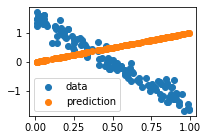

In [12]:
net, y_hat = run(net, x)
plot_prediction(x, y, y_hat)
print(net)

It is inconvenient that we have to _manually_ create a function and decorate it with `pax.pure` every time we want to run a method. 
PAX provides the utility function `pax.module_and_value` that does the job for us. Below is a more convenient implementation:

In [13]:
net, y_hat = pax.module_and_value(net)(x)

To train our model, we need a loss function. In this case, we will define a _mean squared error (MSE)_ loss function as follows:

In [14]:
def mse_loss(model: Linear, x, y):
    model, y_hat = pax.module_and_value(model)(x)
    loss = jnp.mean(jnp.square(y - y_hat))
    return loss, model

It is important that we return the updated model in the output of `mse_loss`.
This is required to make the updated model available outside of the loss function.

Next, we will implement a simple stochastic gradient descent (SGD) optimizer to update trainable parameters of our model.

In [15]:
def sgd(params: Linear, gradients: Linear, lr: float = 1e-1):
    updated_params = jax.tree_map(lambda p, g: p - lr * g, params, gradients)
    return updated_params

Lastly, we need an update function that represents a single training step.

In [16]:
@jax.jit
def update_fn(net: Linear, x, y):
    (loss, net), grads = pax.value_and_grad(mse_loss, has_aux=True)(net, x, y)
    params = net.parameters()
    params = sgd(params, grads)
    net = net.update_parameters(params)
    return net, loss

The function `pax.value_and_grad` is a thin wrapper of `jax.value_and_grad`. It computes gradients with respect to *trainable* parameters of the model.
We use it to transform the `mse_loss` function into a function that returns both `(loss, net)` and the gradients `grads`.

Also, `net.parameters()` returns trainable parameters of the model and `net.update_parameters(params)` returns a new model with parameters updated.

OK, let's train the model for 500 steps:

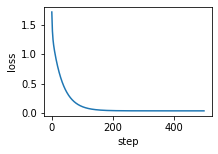

In [17]:
losses = []

for step in range(500):
    net, loss = update_fn(net, x, y)
    losses.append(loss)

plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

In [18]:
net

Linear(weight=-3.023, bias=1.496, counter=502)

Finally, let's plot the predictions of our trained model.

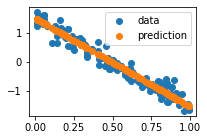

In [19]:
net, y_hat = pax.module_and_value(net)(x)
plot_prediction(x, y, y_hat)